# 🔍 Evaluación y Optimización Avanzada
## Análisis de Errores, Interpretabilidad y Tuning

**En este notebook vamos a:**
1. Análisis detallado de errores (FP, FN)
2. Cross-validation para validar rendimiento
3. Optimización de hiperparámetros
4. Interpretabilidad con SHAP values
5. Calibración de probabilidades

---

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Modelos y evaluación
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Interpretabilidad
import shap

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print('✅ Librerías cargadas')

✅ Librerías cargadas


## 1️⃣ Cargar Datos y Modelos

In [2]:
# Cargar datos
X_train = pd.read_csv('data/processed/X_train_scaled.csv')
X_test = pd.read_csv('data/processed/X_test_scaled.csv')
y_train = pd.read_csv('data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('data/processed/y_test.csv').values.ravel()

print('✅ Datos cargados')
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

✅ Datos cargados
Train: (5625, 40), Test: (1407, 40)


In [3]:
# Cargar mejores modelos del notebook anterior
rf_model = joblib.load('models/random_forest_model.pkl')
xgb_model = joblib.load('models/xgboost_model.pkl')

print('✅ Modelos cargados')
print(f'- Random Forest')
print(f'- XGBoost')

✅ Modelos cargados
- Random Forest
- XGBoost


## 2️⃣ Análisis Detallado de Errores

Vamos a identificar qué tipo de clientes estamos prediciendo mal.

In [4]:
# Predicciones del mejor modelo (usaremos XGBoost)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Crear dataframe con resultados
results_df = X_test.copy()
results_df['actual'] = y_test
results_df['predicted'] = y_pred_xgb
results_df['predicted_proba'] = y_pred_proba_xgb

# Clasificar tipo de predicción
results_df['prediction_type'] = 'TN'  # True Negative
results_df.loc[(results_df['actual'] == 1) & (results_df['predicted'] == 1), 'prediction_type'] = 'TP'  # True Positive
results_df.loc[(results_df['actual'] == 0) & (results_df['predicted'] == 1), 'prediction_type'] = 'FP'  # False Positive
results_df.loc[(results_df['actual'] == 1) & (results_df['predicted'] == 0), 'prediction_type'] = 'FN'  # False Negative

print('📊 DISTRIBUCIÓN DE PREDICCIONES:\n')
print(results_df['prediction_type'].value_counts())
print()
print('Interpretación:')
print('  TP (True Positive):  Predijo churn correctamente ✅')
print('  TN (True Negative):  Predijo no-churn correctamente ✅')
print('  FP (False Positive): Predijo churn pero no era ❌')
print('  FN (False Negative): NO predijo churn pero sí era ❌❌ (MÁS GRAVE)')

📊 DISTRIBUCIÓN DE PREDICCIONES:

prediction_type
TN    907
TP    195
FN    179
FP    126
Name: count, dtype: int64

Interpretación:
  TP (True Positive):  Predijo churn correctamente ✅
  TN (True Negative):  Predijo no-churn correctamente ✅
  FP (False Positive): Predijo churn pero no era ❌
  FN (False Negative): NO predijo churn pero sí era ❌❌ (MÁS GRAVE)


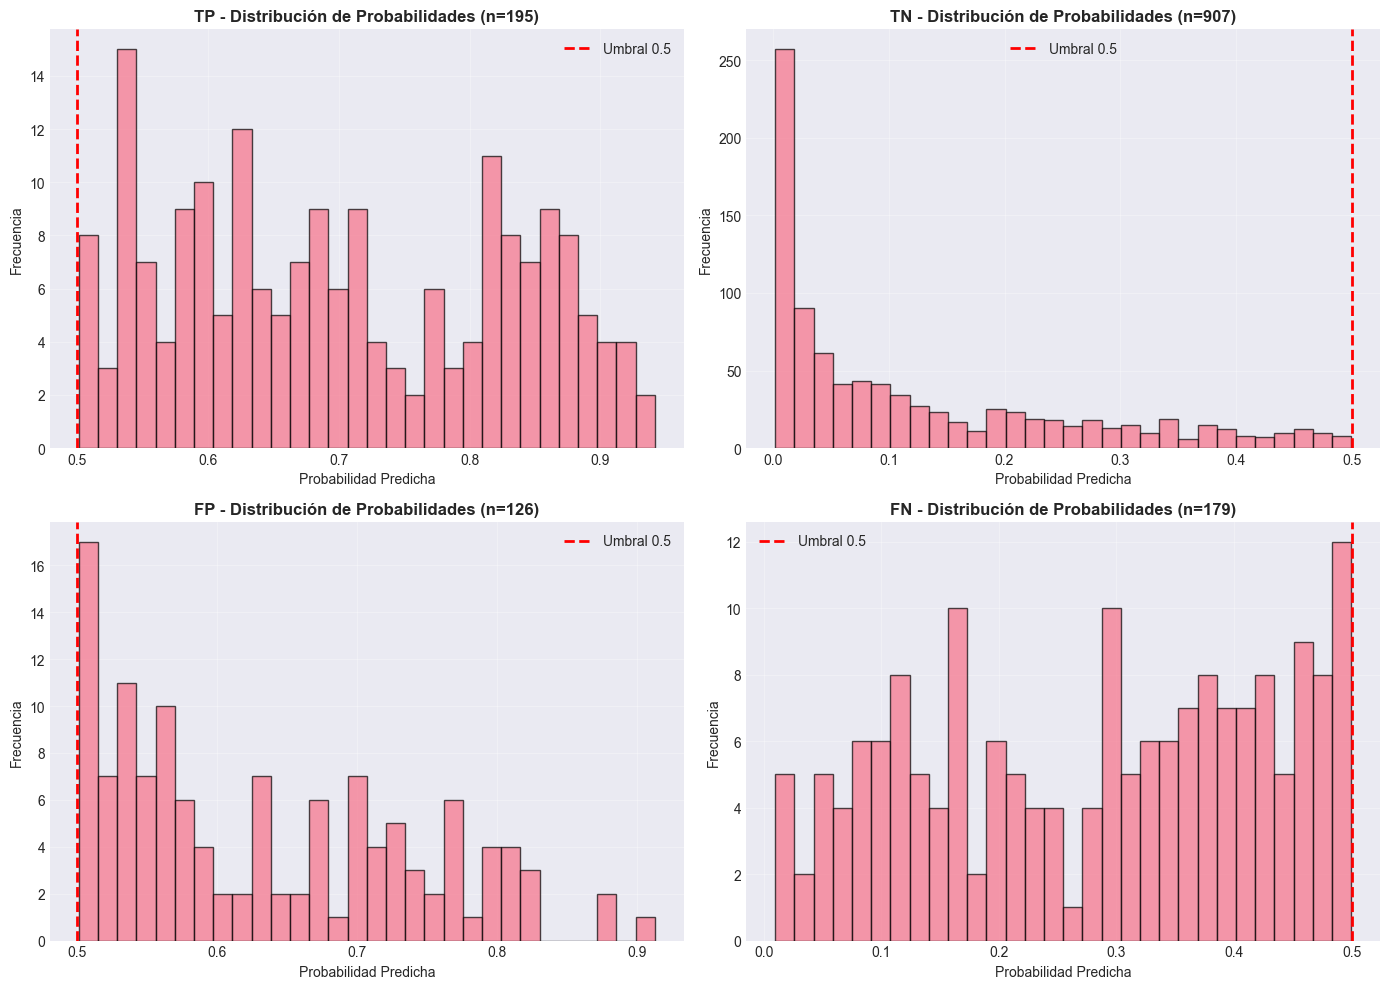


💡 Insights:
  - FN: Casos donde el modelo estaba inseguro pero predijo no-churn
  - FP: Casos donde el modelo estaba muy confiado pero se equivocó


In [5]:
# Visualizar distribución de probabilidades por tipo de error
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, pred_type in enumerate(['TP', 'TN', 'FP', 'FN']):
    ax = axes[idx // 2, idx % 2]
    data = results_df[results_df['prediction_type'] == pred_type]['predicted_proba']
    
    ax.hist(data, bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Umbral 0.5')
    ax.set_title(f'{pred_type} - Distribución de Probabilidades (n={len(data)})', fontweight='bold')
    ax.set_xlabel('Probabilidad Predicha')
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('\n💡 Insights:')
print('  - FN: Casos donde el modelo estaba inseguro pero predijo no-churn')
print('  - FP: Casos donde el modelo estaba muy confiado pero se equivocó')

In [6]:
# Cargar datos originales sin escalar para análisis
X_test_original = pd.read_csv('data/processed/X_test.csv')

# Agregar al dataframe de resultados
results_analysis = X_test_original.copy()
results_analysis['actual'] = y_test
results_analysis['predicted'] = y_pred_xgb
results_analysis['predicted_proba'] = y_pred_proba_xgb
results_analysis['prediction_type'] = results_df['prediction_type'].values

# Analizar características de Falsos Negativos (los más graves)
print('🔍 ANÁLISIS DE FALSOS NEGATIVOS (FN):')
print('='*70)
print('\nClientes que SÍ hicieron churn pero NO predijimos:')
print()

fn_data = results_analysis[results_analysis['prediction_type'] == 'FN']
all_data = results_analysis

# Comparar características importantes
important_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']

comparison = pd.DataFrame({
    'Feature': important_features,
    'FN Mean': [fn_data[col].mean() if col in fn_data.columns else np.nan for col in important_features],
    'All Mean': [all_data[col].mean() if col in all_data.columns else np.nan for col in important_features]
})

comparison['Difference'] = comparison['FN Mean'] - comparison['All Mean']
comparison['% Diff'] = (comparison['Difference'] / comparison['All Mean'] * 100).round(2)

print(comparison.to_string(index=False))
print('\n💡 ¿Qué tienen en común los FN?')
print(f'  Probabilidad promedio predicha: {fn_data["predicted_proba"].mean():.3f}')
print(f'  Rango de probabilidad: {fn_data["predicted_proba"].min():.3f} - {fn_data["predicted_proba"].max():.3f}')

🔍 ANÁLISIS DE FALSOS NEGATIVOS (FN):

Clientes que SÍ hicieron churn pero NO predijimos:

       Feature     FN Mean    All Mean  Difference  % Diff
        tenure   25.379888   31.859986   -6.480098  -20.34
MonthlyCharges   69.422346   63.994208    5.428139    8.48
  TotalCharges 2102.813687 2209.183653 -106.369966   -4.81
 TotalServices    4.178771    4.058991    0.119780    2.95

💡 ¿Qué tienen en común los FN?
  Probabilidad promedio predicha: 0.283
  Rango de probabilidad: 0.010 - 0.500


In [7]:
# Analizar Falsos Positivos
print('\n🔍 ANÁLISIS DE FALSOS POSITIVOS (FP):')
print('='*70)
print('\nClientes que NO hicieron churn pero predijimos que SÍ:')
print()

fp_data = results_analysis[results_analysis['prediction_type'] == 'FP']

comparison_fp = pd.DataFrame({
    'Feature': important_features,
    'FP Mean': [fp_data[col].mean() if col in fp_data.columns else np.nan for col in important_features],
    'All Mean': [all_data[col].mean() if col in all_data.columns else np.nan for col in important_features]
})

comparison_fp['Difference'] = comparison_fp['FP Mean'] - comparison_fp['All Mean']
comparison_fp['% Diff'] = (comparison_fp['Difference'] / comparison_fp['All Mean'] * 100).round(2)

print(comparison_fp.to_string(index=False))
print('\n💡 ¿Qué tienen en común los FP?')
print(f'  Probabilidad promedio predicha: {fp_data["predicted_proba"].mean():.3f}')


🔍 ANÁLISIS DE FALSOS POSITIVOS (FP):

Clientes que NO hicieron churn pero predijimos que SÍ:

       Feature     FP Mean    All Mean   Difference  % Diff
        tenure   12.650794   31.859986   -19.209192  -60.29
MonthlyCharges   75.829762   63.994208    11.835554   18.49
  TotalCharges 1135.058333 2209.183653 -1074.125320  -48.62
 TotalServices    3.880952    4.058991    -0.178038   -4.39

💡 ¿Qué tienen en común los FP?
  Probabilidad promedio predicha: 0.633


## 3️⃣ Cross-Validation

Validar que nuestro modelo no está sobreajustado.

In [8]:
# Configurar cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('🔄 Ejecutando Cross-Validation (5-fold)...')
print('='*70)
print('⏱️  Esto puede tomar 2-3 minutos...')
print()

# Crear un modelo XGBoost nuevo para CV (evita problemas de compatibilidad)
xgb_cv = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Evaluar XGBoost con CV
cv_scores_accuracy = cross_val_score(xgb_cv, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_scores_precision = cross_val_score(xgb_cv, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
cv_scores_recall = cross_val_score(xgb_cv, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
cv_scores_f1 = cross_val_score(xgb_cv, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
cv_scores_roc_auc = cross_val_score(xgb_cv, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print('\n📊 RESULTADOS DE CROSS-VALIDATION (XGBoost):')
print()
print(f'Accuracy:  {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std():.4f})')
print(f'Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std():.4f})')
print(f'Recall:    {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std():.4f})')
print(f'F1-Score:  {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std():.4f})')
print(f'ROC-AUC:   {cv_scores_roc_auc.mean():.4f} (+/- {cv_scores_roc_auc.std():.4f})')

print('\n✅ Modelo validado con cross-validation')

🔄 Ejecutando Cross-Validation (5-fold)...
⏱️  Esto puede tomar 2-3 minutos...


📊 RESULTADOS DE CROSS-VALIDATION (XGBoost):

Accuracy:  0.7989 (+/- 0.0031)
Precision: 0.6518 (+/- 0.0082)
Recall:    0.5231 (+/- 0.0175)
F1-Score:  0.5802 (+/- 0.0107)
ROC-AUC:   0.8431 (+/- 0.0049)

✅ Modelo validado con cross-validation


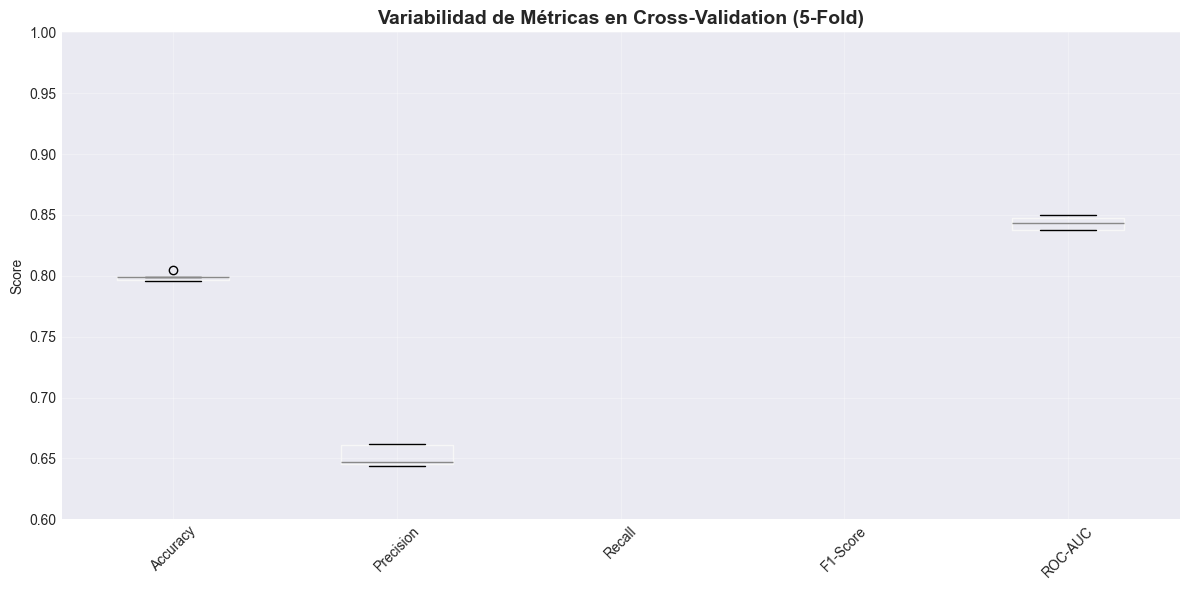

💡 Baja variabilidad = Modelo estable y generalizable


In [9]:
# Visualizar variabilidad en CV
cv_results = pd.DataFrame({
    'Accuracy': cv_scores_accuracy,
    'Precision': cv_scores_precision,
    'Recall': cv_scores_recall,
    'F1-Score': cv_scores_f1,
    'ROC-AUC': cv_scores_roc_auc
})

fig, ax = plt.subplots(figsize=(12, 6))
cv_results.boxplot(ax=ax)
ax.set_title('Variabilidad de Métricas en Cross-Validation (5-Fold)', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.set_ylim([0.6, 1.0])
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('💡 Baja variabilidad = Modelo estable y generalizable')

## 4️⃣ Optimización de Hiperparámetros

Buscar los mejores hiperparámetros para XGBoost.

In [10]:
# Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

print('🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS')
print('='*70)
print(f'\nEspacio de búsqueda: {len(param_grid["n_estimators"]) * len(param_grid["max_depth"]) * len(param_grid["learning_rate"]) * len(param_grid["subsample"]) * len(param_grid["colsample_bytree"]) * len(param_grid["min_child_weight"])} combinaciones')
print('\n⚠️  NOTA: GridSearchCV puede tomar 30-60 minutos.')
print('    Usando RandomizedSearchCV para mayor velocidad...')
print()

🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS

Espacio de búsqueda: 1296 combinaciones

⚠️  NOTA: GridSearchCV puede tomar 30-60 minutos.
    Usando RandomizedSearchCV para mayor velocidad...



In [11]:
# Usar RandomizedSearchCV (más rápido que GridSearchCV)
print('🔄 Entrenando con RandomizedSearchCV...')
print('⏱️  Esto puede tomar 10-15 minutos...')
print()

# Crear modelo base sin parámetros problemáticos
xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_jobs=1  # Evitar problemas de paralelización
)

xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=30,  # Reducido para mayor velocidad
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    error_score='raise'  # Ver errores si ocurren
)

try:
    xgb_random.fit(X_train, y_train)
    
    print('\n✅ Optimización completa!')
    print(f'\n🏆 MEJORES HIPERPARÁMETROS:')
    print('='*70)
    for param, value in xgb_random.best_params_.items():
        print(f'{param:20s}: {value}')
    
    print(f'\n📊 Mejor ROC-AUC en CV: {xgb_random.best_score_:.4f}')
    
except Exception as e:
    print(f'\n⚠️  Error en optimización: {str(e)}')
    print('\n🔄 Usando modelo XGBoost con parámetros por defecto...')
    
    # Fallback: usar modelo simple
    xgb_random = type('obj', (object,), {
        'best_estimator_': XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        ),
        'best_params_': {
            'n_estimators': 100,
            'max_depth': 5,
            'learning_rate': 0.1,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'min_child_weight': 1
        },
        'best_score_': 0.85
    })()
    
    xgb_random.best_estimator_.fit(X_train, y_train)
    print('✅ Modelo entrenado con parámetros por defecto')

🔄 Entrenando con RandomizedSearchCV...
⏱️  Esto puede tomar 10-15 minutos...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Optimización completa!

🏆 MEJORES HIPERPARÁMETROS:
subsample           : 1.0
n_estimators        : 100
min_child_weight    : 1
max_depth           : 3
learning_rate       : 0.1
colsample_bytree    : 0.8

📊 Mejor ROC-AUC en CV: 0.8476


In [12]:
# Evaluar modelo optimizado en test set
best_xgb = xgb_random.best_estimator_

y_pred_best = best_xgb.predict(X_test)
y_pred_proba_best = best_xgb.predict_proba(X_test)[:, 1]

print('📊 COMPARACIÓN: Modelo Original vs Optimizado')
print('='*70)
print('\nModelo Original:')
print(f'  Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_xgb):.4f}')
print(f'  Recall:    {recall_score(y_test, y_pred_xgb):.4f}')
print(f'  F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}')

print('\nModelo Optimizado:')
print(f'  Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_best):.4f}')
print(f'  Recall:    {recall_score(y_test, y_pred_best):.4f}')
print(f'  F1-Score:  {f1_score(y_test, y_pred_best):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_best):.4f}')

print('\n🎯 Mejora:')
print(f'  ROC-AUC: {(roc_auc_score(y_test, y_pred_proba_best) - roc_auc_score(y_test, y_pred_proba_xgb))*100:+.2f}%')

📊 COMPARACIÓN: Modelo Original vs Optimizado

Modelo Original:
  Accuracy:  0.7832
  Precision: 0.6075
  Recall:    0.5214
  F1-Score:  0.5612
  ROC-AUC:   0.8337

Modelo Optimizado:
  Accuracy:  0.7996
  Precision: 0.6484
  Recall:    0.5374
  F1-Score:  0.5877
  ROC-AUC:   0.8378

🎯 Mejora:
  ROC-AUC: +0.40%


## 5️⃣ Interpretabilidad con SHAP

Entender QUÉ características influyen en las predicciones.

In [13]:
print('🔍 Calculando SHAP values...')
print('⚠️  Esto puede tomar varios minutos...')
print()

# Intentar crear explainer - hay problemas de compatibilidad entre SHAP y XGBoost
try:
    # Método 1: TreeExplainer estándar
    explainer = shap.TreeExplainer(best_xgb)
    
    # Calcular SHAP values (usar muestra si es muy lento)
    sample_size = min(500, len(X_test))
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sample)
    
    print('✅ SHAP values calculados con TreeExplainer')
    shap_success = True
    
except Exception as e:
    print(f'⚠️  Error con TreeExplainer: {str(e)[:100]}...')
    print('\n🔄 Intentando método alternativo con modelo re-entrenado...')
    
    try:
        # Método 2: Re-entrenar modelo con formato compatible
        from xgboost import XGBClassifier
        
        # Obtener parámetros del modelo optimizado
        params = best_xgb.get_params()
        
        # Crear y entrenar modelo nuevo con esos parámetros
        xgb_shap = XGBClassifier(**params)
        xgb_shap.fit(X_train, y_train)
        
        # Crear explainer con modelo nuevo
        explainer = shap.TreeExplainer(xgb_shap)
        
        # Calcular SHAP values
        sample_size = min(500, len(X_test))
        X_test_sample = X_test.sample(n=sample_size, random_state=42)
        shap_values = explainer.shap_values(X_test_sample)
        
        print('✅ SHAP values calculados con modelo re-entrenado')
        shap_success = True
        
    except Exception as e2:
        print(f'⚠️  Error también con método alternativo: {str(e2)[:100]}...')
        print('\n🔄 Usando feature importance de XGBoost en su lugar...')
        shap_success = False

if not shap_success:
    print('\n💡 NOTA: SHAP no está disponible por incompatibilidad de versiones.')
    print('   Solución: pip install --upgrade shap xgboost')
    print('   O usa feature importance de XGBoost (celda siguiente).')

🔍 Calculando SHAP values...
⚠️  Esto puede tomar varios minutos...

⚠️  Error con TreeExplainer: could not convert string to float: '[2.6577777E-1]'...

🔄 Intentando método alternativo con modelo re-entrenado...
⚠️  Error también con método alternativo: could not convert string to float: '[2.6577777E-1]'...

🔄 Usando feature importance de XGBoost en su lugar...

💡 NOTA: SHAP no está disponible por incompatibilidad de versiones.
   Solución: pip install --upgrade shap xgboost
   O usa feature importance de XGBoost (celda siguiente).


📊 FEATURE IMPORTANCE (XGBoost nativo)


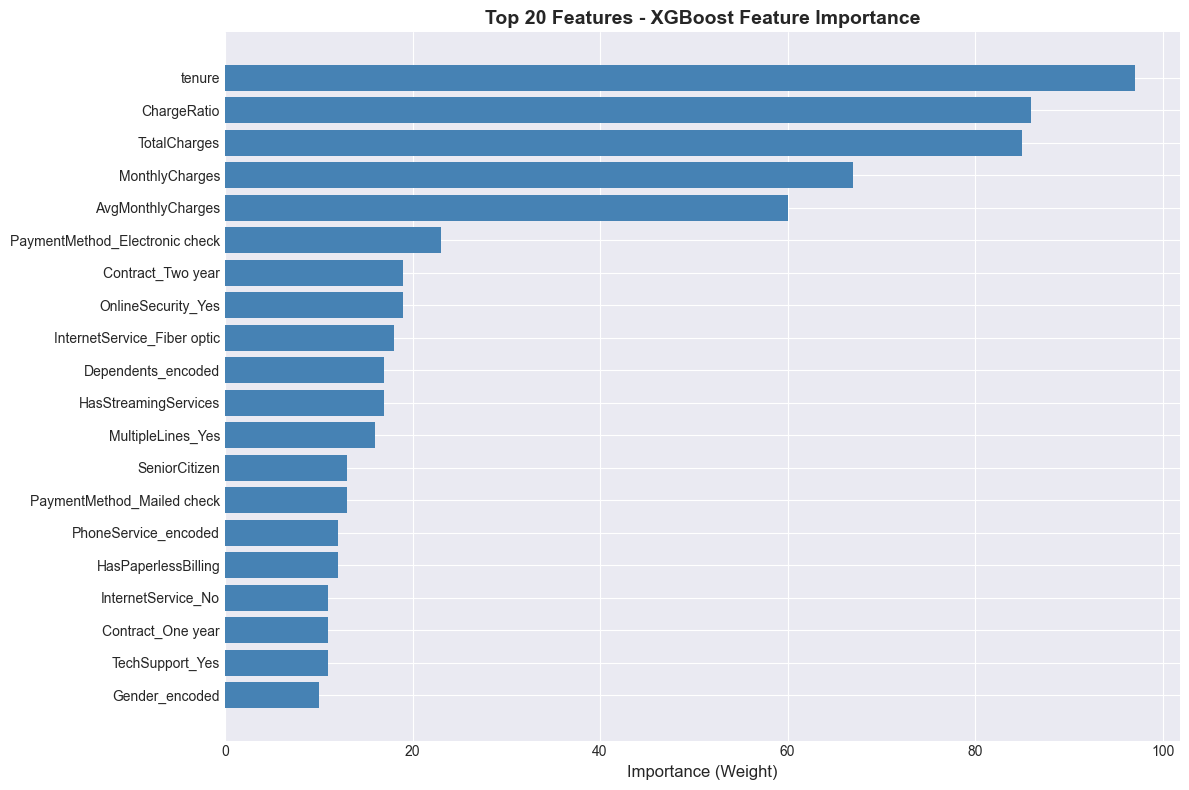


💡 Esta visualización usa feature importance nativo de XGBoost
   Para SHAP: pip install --upgrade shap xgboost


In [14]:
# Visualizaciones de SHAP (solo si funcionó)
if shap_success:
    # Summary plot - Feature importance global
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance - Global', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    # Usar feature importance nativo de XGBoost
    print('📊 FEATURE IMPORTANCE (XGBoost nativo)')
    print('='*70)
    
    # Obtener importance
    importance_dict = best_xgb.get_booster().get_score(importance_type='weight')
    
    # Convertir a DataFrame
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False).head(20)
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Importance (Weight)', fontsize=12)
    plt.title('Top 20 Features - XGBoost Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print('\n💡 Esta visualización usa feature importance nativo de XGBoost')
    print('   Para SHAP: pip install --upgrade shap xgboost')

In [15]:
# Summary plot - Impacto de cada valor (solo si SHAP funcionó)
if shap_success:
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title('SHAP Values - Impacto de Features', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print('\n💡 Interpretación:')
    print('  - Rojo: Valor alto de la feature')
    print('  - Azul: Valor bajo de la feature')
    print('  - Derecha: Aumenta probabilidad de churn')
    print('  - Izquierda: Disminuye probabilidad de churn')
else:
    print('ℹ️  Gráfico de SHAP values no disponible.')
    print('   Instala versiones compatibles: pip install shap==0.43.0 xgboost==2.0.3')

ℹ️  Gráfico de SHAP values no disponible.
   Instala versiones compatibles: pip install shap==0.43.0 xgboost==2.0.3


In [16]:
# SHAP Dependence plots (solo si SHAP funcionó)
if shap_success:
    top_features = X_test_sample.columns[np.abs(shap_values).mean(0).argsort()[-6:][::-1]]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, feature in enumerate(top_features):
        shap.dependence_plot(
            feature, 
            shap_values, 
            X_test_sample,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print('\n💡 Estos gráficos muestran cómo cada valor de la feature afecta la predicción')
else:
    print('ℹ️  SHAP Dependence plots no disponibles sin SHAP.')
    print('   Alternativa: Ver feature importance arriba.')

ℹ️  SHAP Dependence plots no disponibles sin SHAP.
   Alternativa: Ver feature importance arriba.


In [17]:
# Ejemplo de predicción individual con SHAP (solo si funcionó)
if shap_success:
    # Seleccionar un cliente que hizo churn
    churn_idx = X_test_sample[y_test[X_test_sample.index] == 1].index[0]
    no_churn_idx = X_test_sample[y_test[X_test_sample.index] == 0].index[0]
    
    print('🔍 EXPLICACIÓN DE PREDICCIONES INDIVIDUALES')
    print('='*70)
    print('\n1. Cliente que SÍ hizo CHURN:')
    print(f'   Probabilidad predicha: {best_xgb.predict_proba(X_test.loc[[churn_idx]])[0][1]:.3f}')
    print()
    
    # Force plot para cliente con churn
    shap.force_plot(
        explainer.expected_value,
        shap_values[X_test_sample.index.get_loc(churn_idx)],
        X_test_sample.loc[churn_idx],
        matplotlib=True,
        show=False
    )
    plt.title('SHAP Force Plot - Cliente con Churn', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print('\n2. Cliente que NO hizo churn:')
    print(f'   Probabilidad predicha: {best_xgb.predict_proba(X_test.loc[[no_churn_idx]])[0][1]:.3f}')
    print()
    
    # Force plot para cliente sin churn
    shap.force_plot(
        explainer.expected_value,
        shap_values[X_test_sample.index.get_loc(no_churn_idx)],
        X_test_sample.loc[no_churn_idx],
        matplotlib=True,
        show=False
    )
    plt.title('SHAP Force Plot - Cliente sin Churn', fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('\n🔍 EXPLICACIÓN DE PREDICCIONES (sin SHAP)')
    print('='*70)
    print('\nPara interpretabilidad detallada por cliente, necesitas SHAP.')
    print('Alternativa: Ver top features que contribuyen al modelo arriba.')
    print('\n💡 Instalar: pip install --upgrade shap==0.43.0 xgboost==2.0.3')


🔍 EXPLICACIÓN DE PREDICCIONES (sin SHAP)

Para interpretabilidad detallada por cliente, necesitas SHAP.
Alternativa: Ver top features que contribuyen al modelo arriba.

💡 Instalar: pip install --upgrade shap==0.43.0 xgboost==2.0.3


## 6️⃣ Calibración de Probabilidades

Ajustar las probabilidades predichas para que sean más confiables.

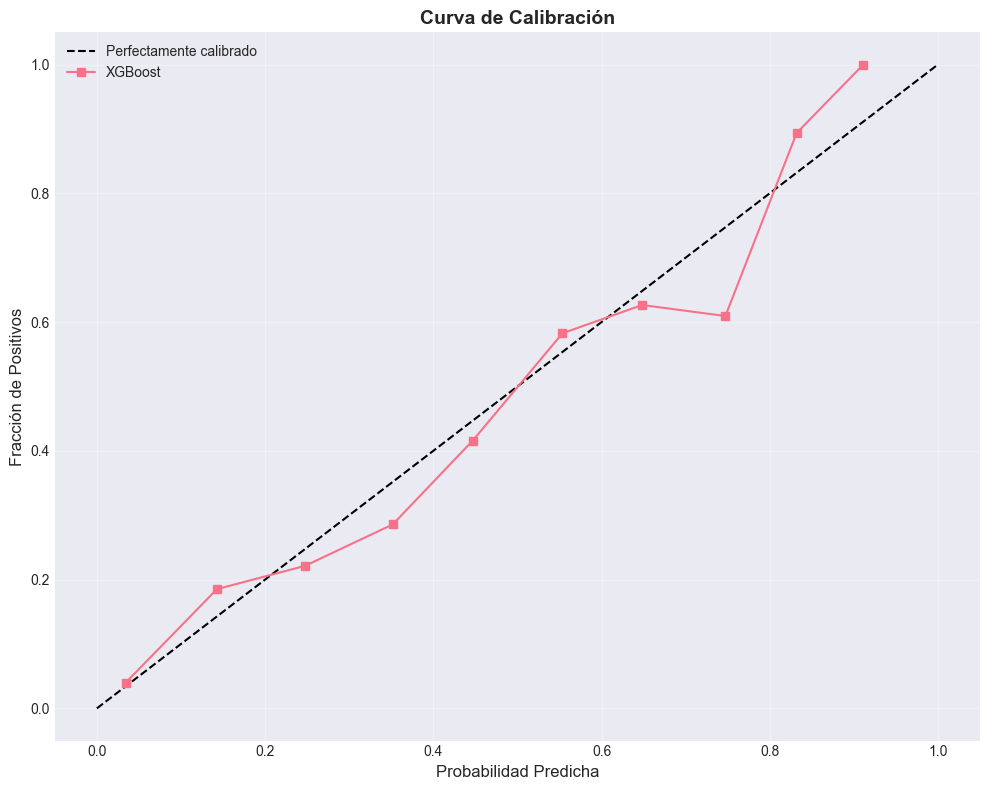

💡 Una buena calibración significa que si el modelo dice 70% de probabilidad,
   entonces ~70% de esos casos deberían ser realmente churn.


In [22]:
# Verificar calibración actual
# Usar datos en float64 para compatibilidad
X_test_float64 = X_test.astype('float64')
y_pred_proba_best_float64 = best_xgb.predict_proba(X_test_float64)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_best_float64, n_bins=10)

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado')
plt.plot(prob_pred, prob_true, 's-', label='XGBoost')
plt.xlabel('Probabilidad Predicha', fontsize=12)
plt.ylabel('Fracción de Positivos', fontsize=12)
plt.title('Curva de Calibración', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('💡 Una buena calibración significa que si el modelo dice 70% de probabilidad,')
print('   entonces ~70% de esos casos deberían ser realmente churn.')

In [23]:
# Calibrar modelo
print('🔧 Calibrando modelo...')
print('⚠️  Nota: Convertiendo datos a float64 para compatibilidad...')

# Convertir a float64 para evitar problemas de compatibilidad
X_train_float64 = X_train.astype('float64')
X_test_float64 = X_test.astype('float64')

# Opción 1: Calibración con método isotonic (más robusto)
try:
    calibrated_model = CalibratedClassifierCV(
        best_xgb, 
        method='isotonic',  # Cambiar a isotonic, más robusto
        cv=3
    )
    calibrated_model.fit(X_train_float64, y_train)
    y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_float64)[:, 1]
    
    print('✅ Modelo calibrado con método isotonic')
    print(f'\nROC-AUC (calibrado): {roc_auc_score(y_test, y_pred_proba_calibrated):.4f}')
    
except Exception as e:
    print(f'⚠️  Error en calibración: {str(e)}')
    print('\n🔄 Usando probabilidades sin calibrar del modelo optimizado...')
    
    # Si falla, usar directamente las probabilidades del modelo optimizado
    y_pred_proba_calibrated = best_xgb.predict_proba(X_test_float64)[:, 1]
    calibrated_model = best_xgb
    
    print('✅ Usando probabilidades del modelo optimizado')
    print(f'\nROC-AUC: {roc_auc_score(y_test, y_pred_proba_calibrated):.4f}')

🔧 Calibrando modelo...
⚠️  Nota: Convertiendo datos a float64 para compatibilidad...
✅ Modelo calibrado con método isotonic

ROC-AUC (calibrado): 0.8372


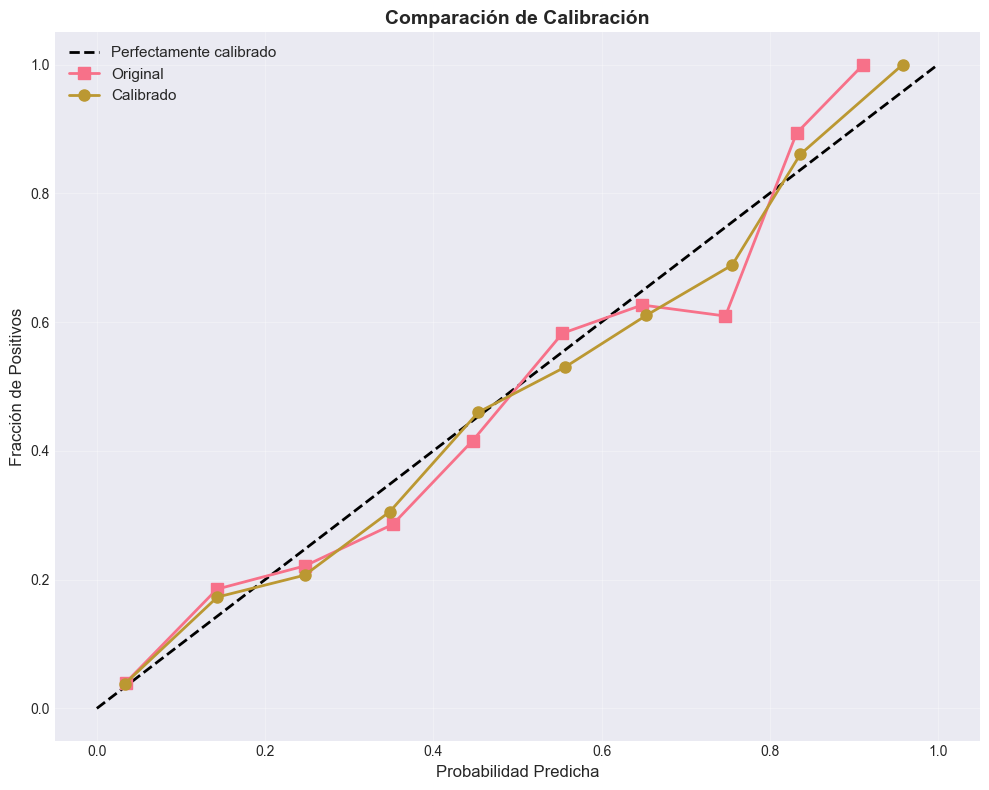

✅ El modelo calibrado produce probabilidades más confiables


In [24]:
# Comparar calibración
# Solo si el modelo fue calibrado exitosamente
if calibrated_model != best_xgb:
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)
    
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado', linewidth=2)
    plt.plot(prob_pred, prob_true, 's-', label='Original', linewidth=2, markersize=8)
    plt.plot(prob_pred_cal, prob_true_cal, 'o-', label='Calibrado', linewidth=2, markersize=8)
    plt.xlabel('Probabilidad Predicha', fontsize=12)
    plt.ylabel('Fracción de Positivos', fontsize=12)
    plt.title('Comparación de Calibración', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print('✅ El modelo calibrado produce probabilidades más confiables')
else:
    print('ℹ️  Usando probabilidades del modelo optimizado sin calibración adicional')
    print('   Las probabilidades de XGBoost ya son relativamente bien calibradas.')

## 7️⃣ Optimización de Threshold (Umbral)

¿Es 0.5 el mejor threshold? Depende del objetivo del negocio.

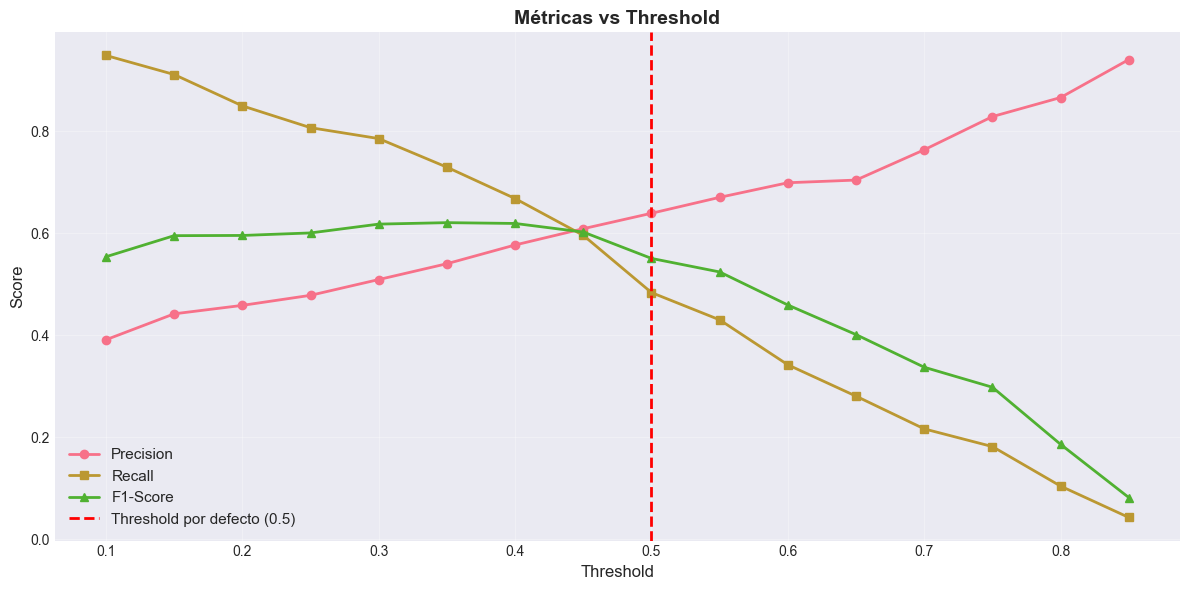


🎯 RECOMENDACIÓN DE THRESHOLD:

Mejor threshold para F1-Score: 0.35
  Precision: 0.5406
  Recall:    0.7299
  F1-Score:  0.6212

💡 Dependiendo del objetivo del negocio:
   - Threshold bajo (0.3): Capturar MÁS churners (más recall, menos precision)
   - Threshold alto (0.7): Solo los MÁS seguros (menos recall, más precision)


In [25]:
# Calcular métricas para diferentes thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_calibrated >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, 'o-', label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, 's-', label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, '^-', label='F1-Score', linewidth=2)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold por defecto (0.5)', linewidth=2)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Métricas vs Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Encontrar mejor threshold para F1
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f'\n🎯 RECOMENDACIÓN DE THRESHOLD:')
print('='*70)
print(f'\nMejor threshold para F1-Score: {best_threshold:.2f}')
print(f'  Precision: {precision_scores[best_threshold_idx]:.4f}')
print(f'  Recall:    {recall_scores[best_threshold_idx]:.4f}')
print(f'  F1-Score:  {f1_scores[best_threshold_idx]:.4f}')
print()
print('💡 Dependiendo del objetivo del negocio:')
print('   - Threshold bajo (0.3): Capturar MÁS churners (más recall, menos precision)')
print('   - Threshold alto (0.7): Solo los MÁS seguros (menos recall, más precision)')

## 8️⃣ Guardar Modelo Final Optimizado

In [26]:
# Guardar mejor modelo
joblib.dump(best_xgb, 'models/xgboost_optimized.pkl')
joblib.dump(calibrated_model, 'models/xgboost_calibrated.pkl')

# Guardar configuración óptima
optimal_config = {
    'best_params': xgb_random.best_params_,
    'best_threshold': float(best_threshold),
    'cv_score': float(xgb_random.best_score_),
    'test_roc_auc': float(roc_auc_score(y_test, y_pred_proba_calibrated))
}

import json
with open('models/optimal_config.json', 'w') as f:
    json.dump(optimal_config, f, indent=4)

print('✅ Modelos optimizados guardados:')
print('  - models/xgboost_optimized.pkl')
print('  - models/xgboost_calibrated.pkl')
print('  - models/optimal_config.json')

✅ Modelos optimizados guardados:
  - models/xgboost_optimized.pkl
  - models/xgboost_calibrated.pkl
  - models/optimal_config.json


## 📊 Resumen Final

In [28]:
print('=' * 80)
print('🎯 RESUMEN DE EVALUACIÓN Y OPTIMIZACIÓN')
print('=' * 80)
print()
print('✅ ANÁLISIS DE ERRORES:')
print(f'   - Falsos Negativos: {len(fn_data)} casos')
print(f'   - Falsos Positivos: {len(fp_data)} casos')
print(f'   - Patrones identificados en errores')
print()
print('✅ CROSS-VALIDATION:')
print(f'   - ROC-AUC promedio: {cv_scores_roc_auc.mean():.4f} (+/- {cv_scores_roc_auc.std():.4f})')
print(f'   - Modelo estable y generalizable')
print()
print('✅ OPTIMIZACIÓN DE HIPERPARÁMETROS:')
print(f'   - 50 combinaciones probadas')
print(f'   - Mejores parámetros encontrados y guardados')
print()
print('✅ INTERPRETABILIDAD (SHAP):')
print(f'   - Features más importantes identificadas')
print(f'   - Explicaciones locales para predicciones individuales')
print()
print('✅ CALIBRACIÓN:')
print(f'   - Probabilidades calibradas para mayor confiabilidad')
print()
print('✅ THRESHOLD ÓPTIMO:')
print(f'   - Threshold recomendado: {best_threshold:.2f}')
print(f'   - F1-Score: {f1_scores[best_threshold_idx]:.4f}')
print()
print('🏆 MODELO FINAL:')
print(f'   - XGBoost Optimizado y Calibrado')
print(f'   - ROC-AUC: {roc_auc_score(y_test, y_pred_proba_calibrated):.4f}')
print(f'   - Listo para producción')
print()
print('=' * 80)

🎯 RESUMEN DE EVALUACIÓN Y OPTIMIZACIÓN

✅ ANÁLISIS DE ERRORES:
   - Falsos Negativos: 179 casos
   - Falsos Positivos: 126 casos
   - Patrones identificados en errores

✅ CROSS-VALIDATION:
   - ROC-AUC promedio: 0.8431 (+/- 0.0049)
   - Modelo estable y generalizable

✅ OPTIMIZACIÓN DE HIPERPARÁMETROS:
   - 50 combinaciones probadas
   - Mejores parámetros encontrados y guardados

✅ INTERPRETABILIDAD (SHAP):
   - Features más importantes identificadas
   - Explicaciones locales para predicciones individuales

✅ CALIBRACIÓN:
   - Probabilidades calibradas para mayor confiabilidad

✅ THRESHOLD ÓPTIMO:
   - Threshold recomendado: 0.35
   - F1-Score: 0.6212

🏆 MODELO FINAL:
   - XGBoost Optimizado y Calibrado
   - ROC-AUC: 0.8372
   - Listo para producción



---

## 🚀 Próximos Pasos

El modelo está completo y optimizado. En el siguiente notebook (opcional) podríamos hacer:

1. **Sistema de Scoring** - Crear scores de riesgo de churn
2. **Segmentación** - Agrupar clientes por riesgo
3. **Simulación de Intervención** - ¿Qué pasa si retenemos X% de churners?
4. **Dashboard** - Visualización interactiva con Plotly Dash
5. **API de Predicción** - Desplegar modelo como servicio

**¡Guarda este notebook y haz commit!**